In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

from entities_recognition.bilstm.train import trainIters, evaluate_all
from config import START_TAG, STOP_TAG

In [2]:
TRAIN_PATH = path.join(BASE_PATH, 'data/CoNLL-2003/eng.train')
print(TRAIN_PATH)

/Users/2359media/Documents/botbot-nlp/data/CoNLL-2003/eng.train


In [3]:
import io
import string

def ident(x):
    return x

def read_conll_2003(filename):
    all_data = []

    current_txt = []
    current_tags = []
    tagset = []

    fin = io.open(filename, 'r', encoding='utf-8', newline='\n', errors='ignore')
    for line in fin:
        line = line.strip()
        if len(line) > 0: # skip blank lines
            tmp = line.split(' ')
            if tmp[0] != '-DOCSTART-':
                current_txt.append(tmp[0])
                current_tags.append(tmp[-1])
                tagset.append(tmp[-1])
        else:
            if len(current_txt) > 0:
                all_data.append((current_txt, ' '.join(current_tags)))
                current_txt = []
                current_tags = []
    fin.close()

    tagset = list(set(tagset))
    tag_to_ix = {tag: key for key, tag in enumerate(tagset)}
    tag_to_ix[START_TAG] = len(tagset)
    tag_to_ix[STOP_TAG] = len(tagset) + 1

    print(tag_to_ix)
    print('Loaded %s sentences' % len(all_data))
    
    return tag_to_ix, all_data

In [4]:
from entities_recognition.bilstm.predict import read_tags

tag_to_ix, training_data = read_conll_2003(TRAIN_PATH)
result = []
for sentence, tag_seq in training_data:
    assert len(sentence) == len(tag_seq.split(' '))
#     print(read_tags(tokens_in, tag_seq.split(' ')))

{'I-PER': 0, 'I-MISC': 1, 'O': 2, 'I-LOC': 3, 'B-MISC': 4, 'I-ORG': 5, 'B-LOC': 6, 'B-ORG': 7, '<START>': 8, '<STOP>': 9}
Loaded 14041 sentences


Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
21m 17s (- 1043m 14s) (1 2%) 31360.4160
41m 54s (- 1005m 56s) (2 4%) 19920.6328
64m 48s (- 1015m 12s) (3 6%) 16872.8555
93m 27s (- 1074m 51s) (4 8%) 14861.2920
116m 6s (- 1044m 56s) (5 10%) 13296.4102
148m 37s (- 1089m 53s) (6 12%) 11332.8350
185m 5s (- 1137m 0s) (7 14%) 10432.2285
210m 39s (- 1105m 57s) (8 16%) 9602.6963
244m 27s (- 1113m 38s) (9 18%) 9025.2783
274m 3s (- 1096m 14s) (10 20%) 8297.2754
303m 21s (- 1075m 33s) (11 22%) 7534.7310
337m 57s (- 1070m 12s) (12 24%) 7347.6221
518m 45s (- 1476m 29s) (13 26%) 6635.0420
550m 2s (- 1414m 23s) (14 28%) 6345.6074
577m 18s (- 1347m 2s) (15 30%) 6063.8989
607m 37s (- 1291m 12s) (16 32%) 5538.7007
638m 11s (- 1238m 50s) (17 34%) 5089.9976
666m 41s (- 1185m 14s) (18 36%) 4783.3892
694m 30s (- 1133m 8s) (19 38%) 4491.3589
722m 21s (- 1083m 32s) (20 40%) 4373.4780
750m 51s (- 1036m 54s) (21 42%) 4223.7148
778m 44s (- 991m 7s) (22 44%) 3766.2349
801m 48s (- 

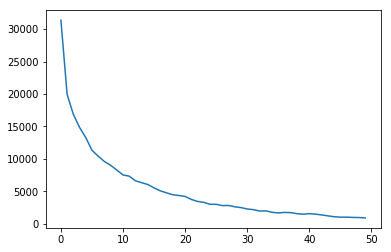

In [5]:
losses, model = trainIters(training_data, 
                           tag_to_ix,
                           learning_rate=1e-3,
                           n_iters=50, 
                           log_every=1,
                           tokenizer=ident,
                           verbose=1)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
plt.plot(losses)

In [6]:
import torch
model.eval()
torch.save(model.state_dict(), 'bilstm-rnn-conll2003-vanilla.bin')

Model recall

In [7]:
evaluate_all(model, training_data, tag_to_ix, tokenizer=ident)

0.9988950059178572

In [8]:
TEST_PATH_A = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testa')
TEST_PATH_B = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testb')
_, testing_data_a = read_conll_2003(TEST_PATH_A)
_, testing_data_b = read_conll_2003(TEST_PATH_B)

{'I-PER': 0, 'I-MISC': 1, 'O': 2, 'I-LOC': 3, 'B-MISC': 4, 'I-ORG': 5, '<START>': 6, '<STOP>': 7}
Loaded 3250 sentences
{'I-PER': 0, 'I-MISC': 1, 'O': 2, 'I-LOC': 3, 'B-MISC': 4, 'I-ORG': 5, 'B-LOC': 6, 'B-ORG': 7, '<START>': 8, '<STOP>': 9}
Loaded 3453 sentences


Accuracy on test sets

In [9]:
evaluate_all(model, testing_data_a, tag_to_ix, tokenizer=ident)

0.9787196760250769

In [10]:
evaluate_all(model, testing_data_b, tag_to_ix, tokenizer=ident)

0.9640572843760095

In [11]:
from entities_recognition.bilstm.predict import predict
from common.utils import wordpunct_tokenize

test_data = [
    'I live in Ho Chi Minh City, nice place, though my hometown is in Hanoi. I do miss it sometimes',
    'Trump’s role in midterm elections roils Republicans',
    'Kenya bans film about 2 girls in love because it’s ‘too hopeful’',
    'G.O.P. leaders and White House aides are trying to prepare President Trump for trouble in House and Senate races.'
]
predict(model, test_data, tag_to_ix, tokenizer=wordpunct_tokenize, delimiter=' ')

Raw predicted tags:
[2, 2, 2, 3, 0, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 1]
[3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 5, 5, 5, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2, 2]


[{'LOC': ['Ho', 'City', 'Hanoi'], 'PER': ['Chi Minh']},
 {'MISC': ['Republicans']},
 {'LOC': ['Kenya']},
 {'LOC': ['White House'], 'ORG': ['O . P', 'House', 'Senate']}]

In [12]:
import json
with open('tag_to_ix.json', 'w') as tagfile:
    json.dump(tag_to_ix, tagfile)

`./conlleval < testa.out.txt`
```
processed 51578 tokens with 5942 phrases; found: 5958 phrases; correct: 5199.
accuracy:  97.93%; precision:  87.26%; recall:  87.50%; FB1:  87.38
              LOC: precision:  91.93%; recall:  91.78%; FB1:  91.86  1834
             MISC: precision:  87.27%; recall:  83.30%; FB1:  85.24  880
              ORG: precision:  78.03%; recall:  83.15%; FB1:  80.51  1429
              PER: precision:  89.81%; recall:  88.49%; FB1:  89.14  1815
```
`./conlleval < testb.out.txt`
```
processed 46666 tokens with 5879 phrases; found: 5703 phrases; correct: 4591.
accuracy:  95.89%; precision:  80.50%; recall:  78.09%; FB1:  79.28
              LOC: precision:  86.08%; recall:  88.61%; FB1:  87.33  1717
             MISC: precision:  71.13%; recall:  73.36%; FB1:  72.23  724
              ORG: precision:  74.11%; recall:  79.11%; FB1:  76.53  1773
              PER: precision:  86.23%; recall:  79.41%; FB1:  82.68  1489
```